# Financial data indices

In [1]:
import json
import math
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={"figure.figsize": (16, 8)})

In [3]:
def filter_positive(dictionary, key, tol = 0.):
    sal = dictionary[key]
    return { k: v for (k, v) in sal.items() if v > tol }

In [61]:
with open("data/saliency.json") as file:
    saliency = json.load(file)


summand_dws =  {key: value + saliency["ANNUAL dws b"].get(key, 0.) for key, value in saliency["ANNUAL dws"].items()}    
saliency["ANNUAL dws"] = { **saliency["ANNUAL dws b"], **summand_dws }

saliency.pop("ANNUAL dws b")

# Combine DWS-a and DWS-b

reports = list(saliency)

saliency = {company: filter_positive(saliency, company, tol=0) for company in reports}

In [62]:
types = ["ANNUAL", "RI_REPORT", "STEWARDSHIP_POLICY", "VOTING_POLICY"]
companies = set()

for report in reports:
    name = report
    for t in types:
        name = name.replace(f"{t} ", "")
        
    companies.add(name)
    
companies = list(companies)

In [63]:
companies

['nn', 'generali', 'apg', 'dws', 'nbim', 'blackrock', 'jpmam']

## Distribution of all saliencies

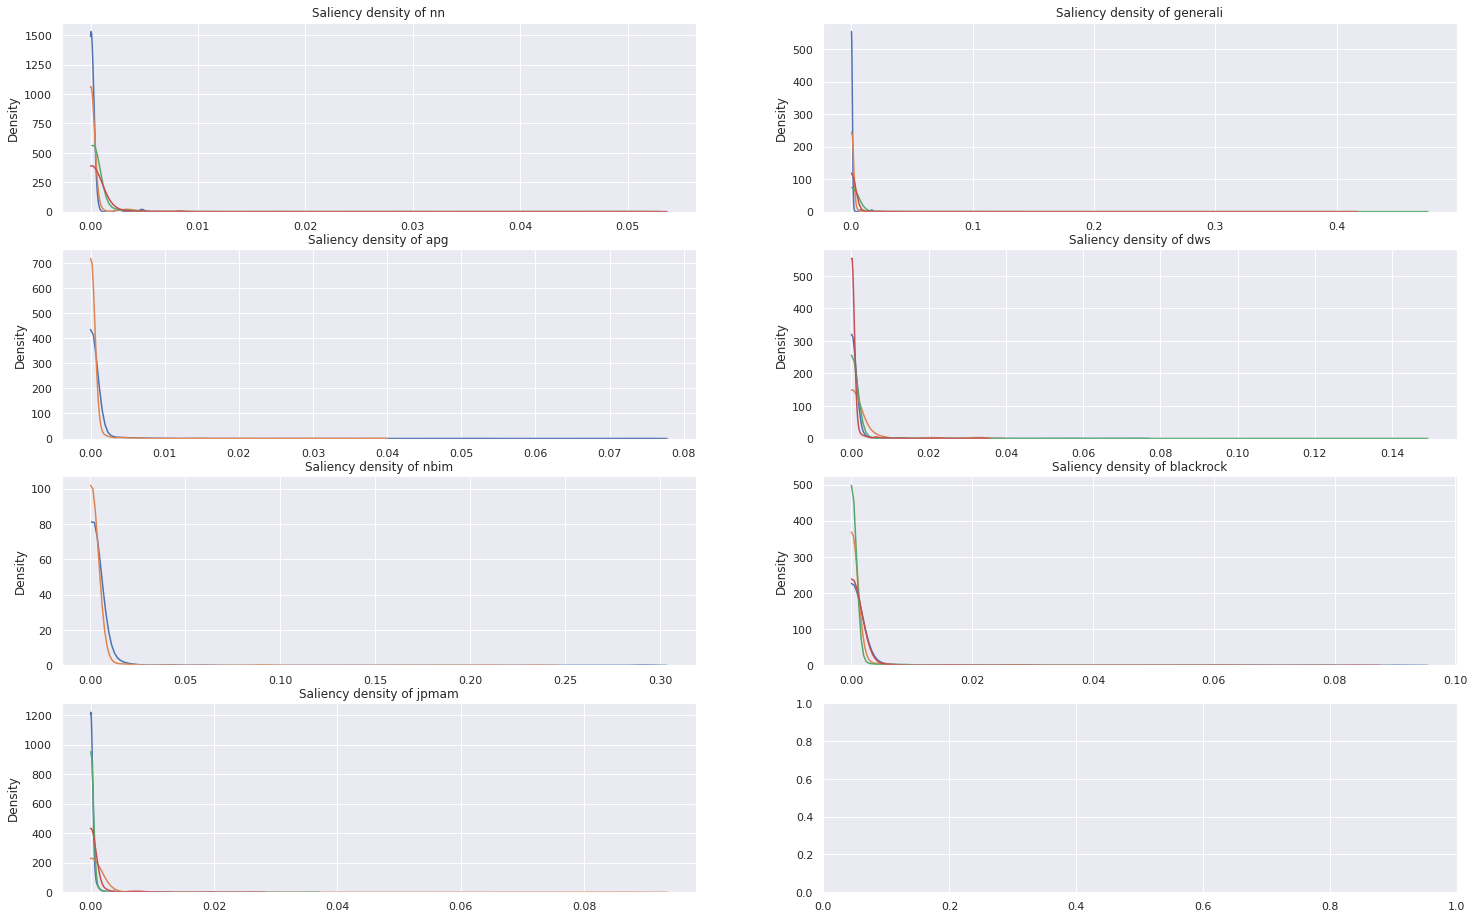

In [64]:
columns = len(companies) // 3
rows = math.ceil(len(companies) / columns)

fig, axes = plt.subplots(rows, columns, figsize = (25, 16))

for i, ax in enumerate(axes.flat):
    if i >= len(companies): break
    company = companies[i]
    
    for t in types:
        key = f"{t} {company}"
        if key in saliency:
            data = list(saliency[key].values())
            lower = min(data)
            if np.var(data) > 0:
                sns.kdeplot(data, ax = ax, clip=(lower, None))
        
    ax.set_title(f"Saliency density of {company}")
    
fig.show()

## Sustainable indices

In [65]:
sustainable_words = [
    "climate", "sustainable", 
    "sustainability", "green", 
    "long", "bioscience", "mitigate", 
    "change", "environment", "environmental"
]

In [76]:
def index(saliency, report, words = sustainable_words):
        
    isinwords = lambda k: any(word in k for word in words)
    
    sal = filter_positive(saliency, report)
    
    total = sum(sal.values())
    sustainable = sum((v for (k, v) in sal.items() if isinwords(k)))
    
    return sustainable/total

In [77]:
groups = types

In [78]:
grouped_data = { g: {} for g in groups }

for report in reports:
    for group in groups:
        if group in report:
            company = report.replace(f"{group} ", "")
            grouped_data[group][company] = index(saliency, report)
            
            continue
            
df = pd.DataFrame.from_dict(grouped_data)

In [82]:
df

,ANNUAL,RI_REPORT,STEWARDSHIP_POLICY,VOTING_POLICY
blackrock,0.000116,0.019503,0.045968,0.002815
dws,0.000467,0.054898,0.013838,0.004475
generali,0.000495,0.007391,0.006605,0.002357
jpmam,0.000000,0.026015,0.072319,0.000074
nn,0.019443,0.031414,0.015417,0.006125
apg,NaN,0.000000,0.036076,0.014895
nbim,NaN,NaN,0.015459,0.004151


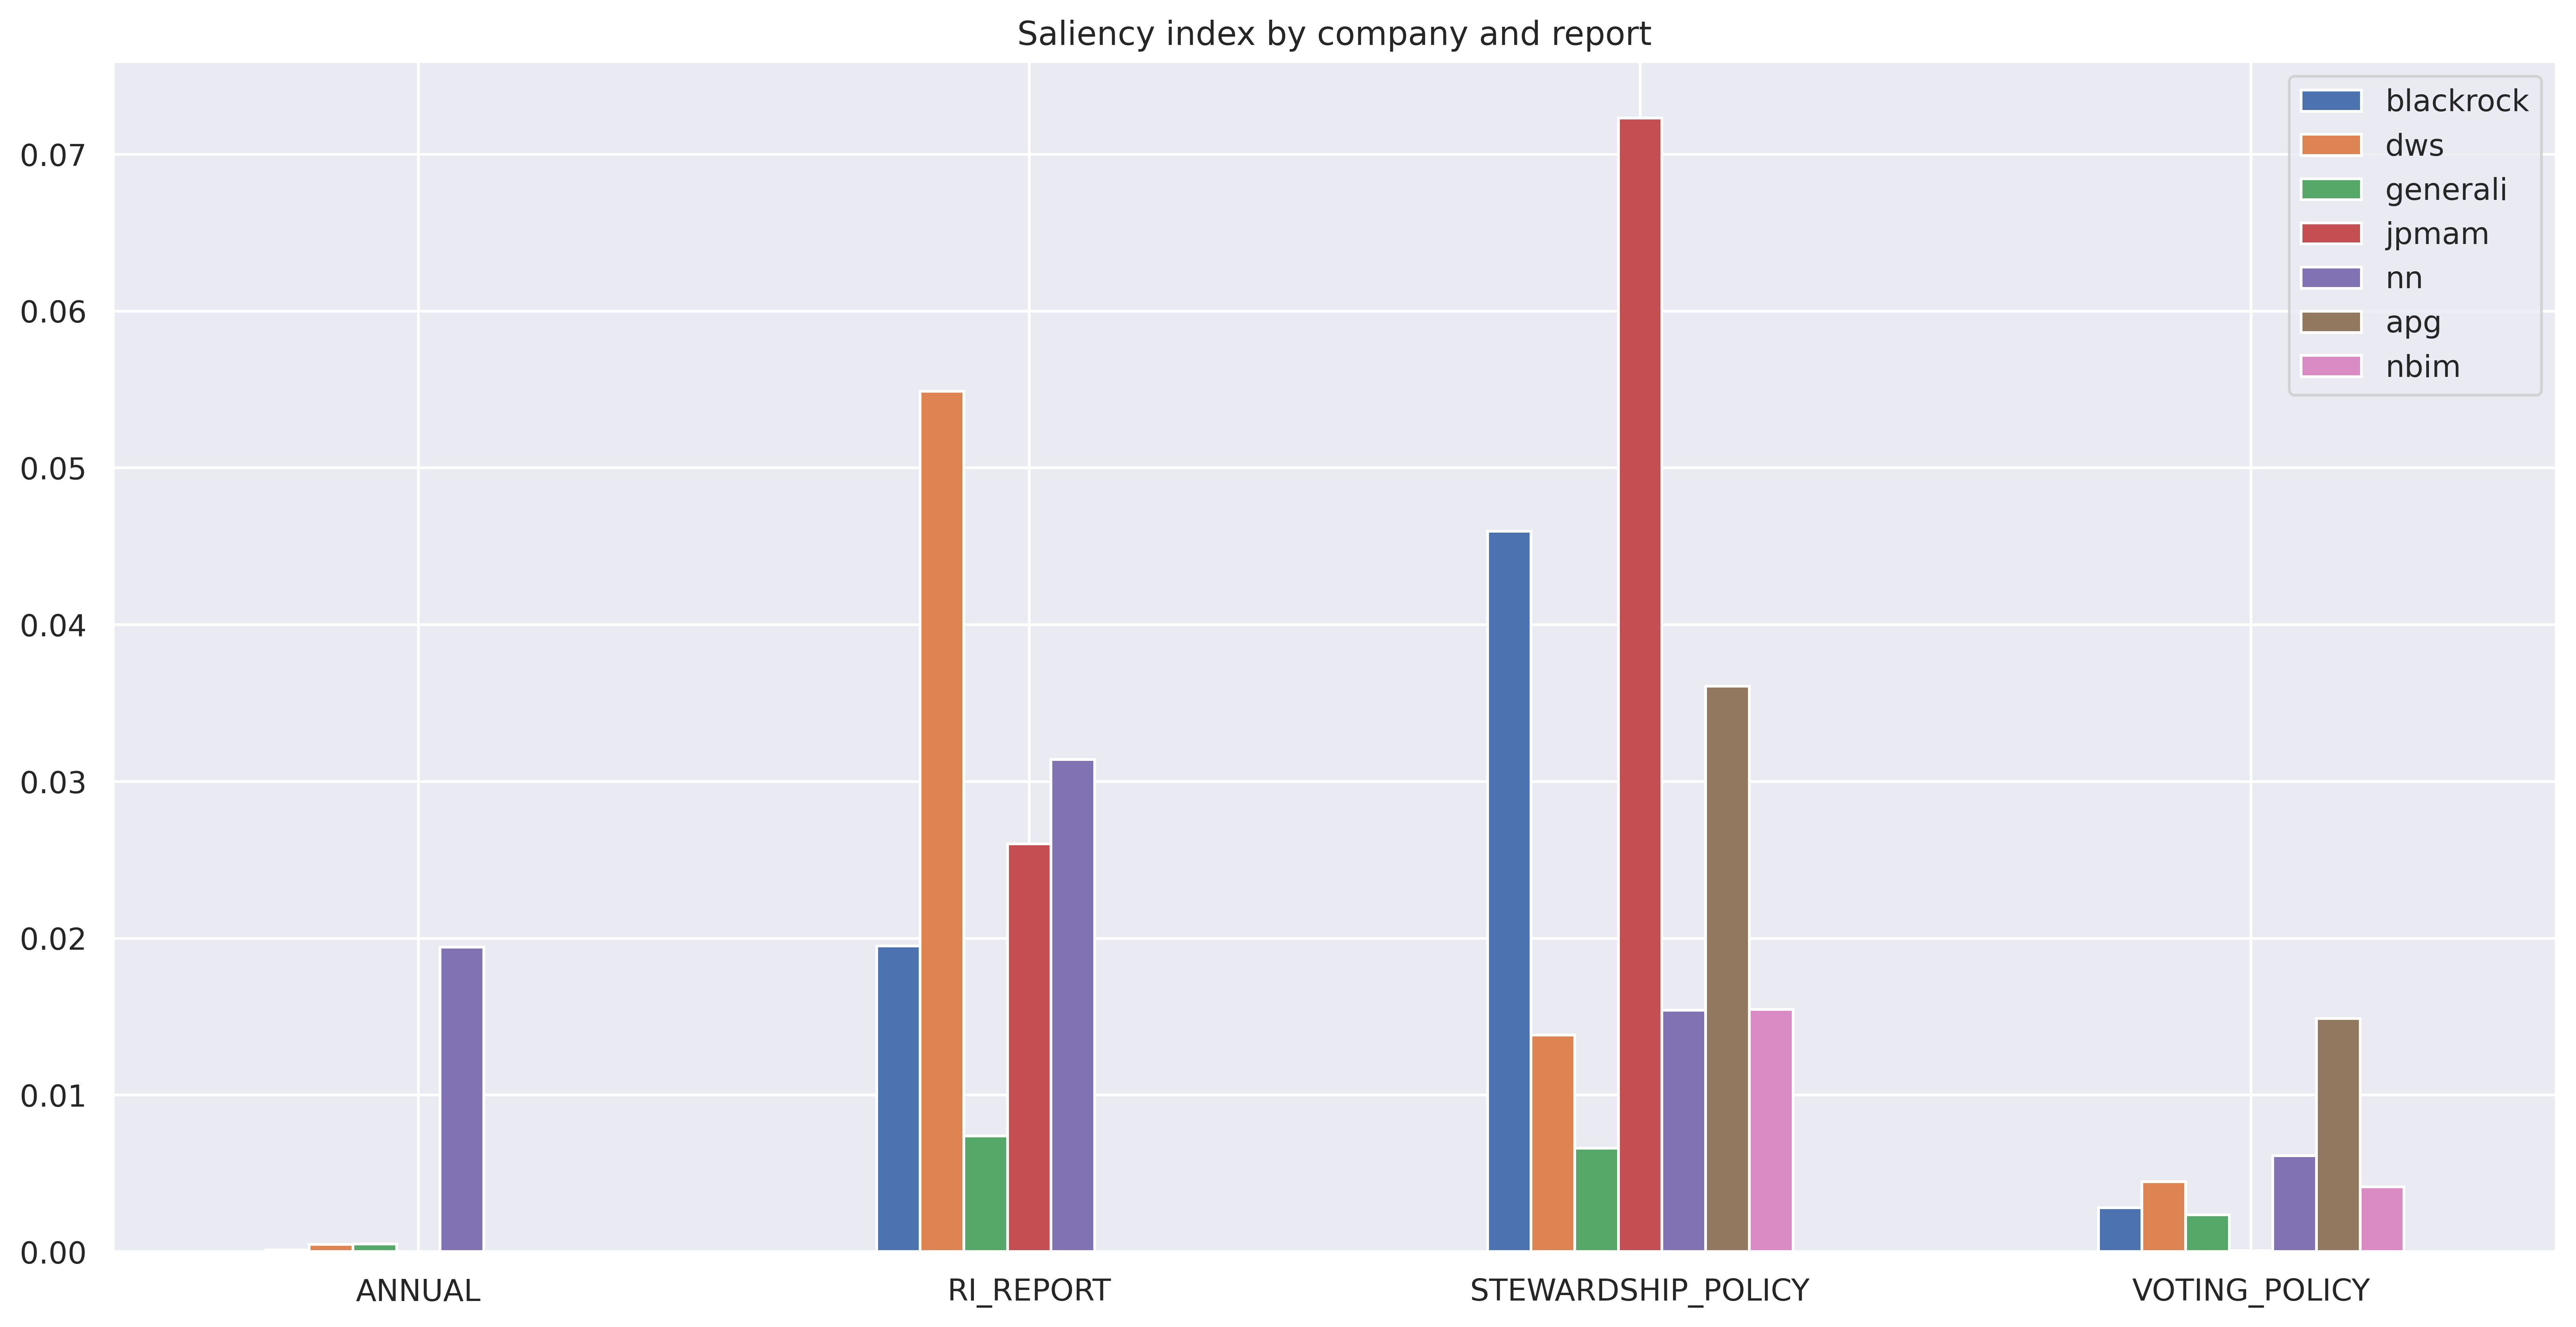

In [79]:
fig, ax = plt.subplots(dpi = 500)
df.T.plot.bar(rot=0, ax=ax)
ax.set_title("Saliency index by company and report")
plt.show()